In [141]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose


In [142]:
data_path = '../data/transformed_output.csv'

In [143]:
df = pd.read_csv(data_path)
df.head(2)

,licencePlate,start_time,end_time,start_lat,start_lon,end_lat,end_lon,travel_time,vehicleTypeId,zipCode,...,type,postcode,zipCodeFixed,end_zipCode,end_postcode,start_area,end_area,route,day_of_week,hour_of_day
0,ce58907,2025-07-22 14:14:49,2025-07-22 15:08:49,55.696949,12.586576,55.696915,12.586560,54,2,2100,...,car,2100,2100,2500.0,2500.0,Kobenhavn O,Valby,Kobenhavn O → Valby,Tuesday,14
1,ce58907,2025-07-22 21:02:01,2025-07-23 06:12:01,55.660629,12.605627,55.660603,12.605632,550,2,2300,...,car,2300,2300,2500.0,2500.0,Kobenhavn S,Valby,Kobenhavn S → Valby,Tuesday,21


In [144]:
df.columns

Index(['licencePlate', 'start_time', 'end_time', 'start_lat', 'start_lon',
       'end_lat', 'end_lon', 'travel_time', 'vehicleTypeId', 'zipCode',
       'model', 'type', 'postcode', 'zipCodeFixed', 'end_zipCode',
       'end_postcode', 'start_area', 'end_area', 'route', 'day_of_week',
       'hour_of_day'],
      dtype='object')

#### Create a movement dataframe

In [145]:
df = df.sort_values(by=['licencePlate', 'start_time']).reset_index(drop=True)

movement_df = df.copy()

# Create the new variables expected by your group member
movement_df['start_move_time'] = movement_df['start_time']
movement_df['end_move_time'] = movement_df['end_time']
movement_df['move_duration'] = movement_df['travel_time']

movement_df = movement_df.dropna(subset=['end_move_time']).copy()

# Rename only the columns that actually need renaming
movement_df = movement_df.rename(columns={
    'zipCodeFixed': 'start_zip',
    'end_zipCode': 'end_zip'
})

# Select columns in the expected order
movement_df = movement_df[[
    'licencePlate',
    'start_move_time',
    'end_move_time',
    'start_lat',
    'start_lon',
    'end_lat',
    'end_lon',
    'start_zip',
    'end_zip',
    'move_duration',
    'vehicleTypeId',
    'type'
]]

In [146]:
n_cars = df['licencePlate'].nunique()
print('Number of cars: ', n_cars
)

Number of cars:  678


### Smoothing

In [147]:
movement_df['start_move_time'] = pd.to_datetime(movement_df['start_move_time'])
movement_df['end_move_time'] = pd.to_datetime(movement_df['end_move_time'])

movement_df['rental_minutes'] = (movement_df['end_move_time'] - movement_df['start_move_time']).dt.total_seconds() / 60

movement_df['date'] = movement_df['start_move_time'].dt.date
daily_use = movement_df.groupby('date')['rental_minutes'].sum().reset_index()
daily_use['total_hours'] = daily_use['rental_minutes'] / 60
daily_use['av_rent_hour_per_car'] = daily_use['total_hours'] / n_cars

In [148]:
# # df['travel_time'] = (df['end_move_time'] - movement_df['start_move_time']).dt.total_seconds() / 60
# df['start_time'] = pd.to_datetime(df['start_time'])
# df['date'] = df['start_time'].dt.date

# daily_use = df.groupby('date')['travel_time'].sum().reset_index()
# daily_use['total_hours'] = daily_use['travel_time'] / 60
# #daily_use['av_rent_hour_per_car'] = daily_use['total_hours'] / n_cars

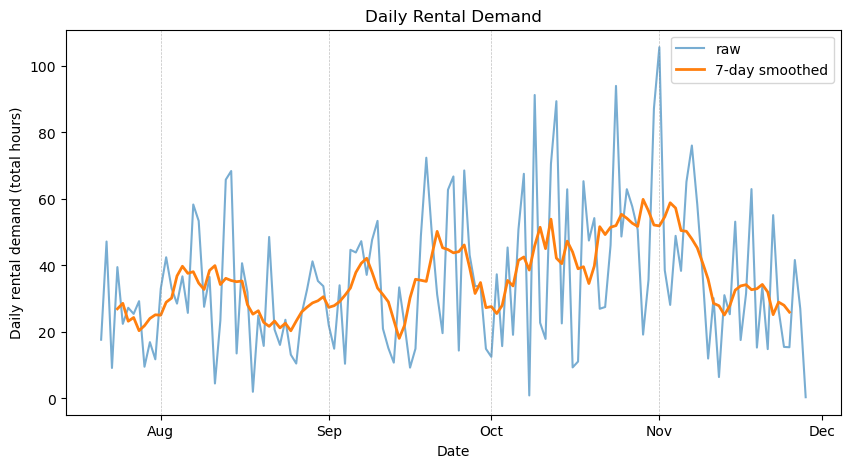

In [149]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

daily_use = daily_use.sort_values('date')

daily_use['rental_smooth'] = daily_use['total_hours'].rolling(window=7, center=True).mean()

# Plot
plt.figure(figsize=(10,5))
plt.plot(daily_use['date'], daily_use['total_hours'], label='raw', alpha=0.6)
plt.plot(daily_use['date'], daily_use['rental_smooth'], label='7-day smoothed', linewidth=2)

# Format x-axis to show months
ax = plt.gca()

for d in pd.date_range(daily_use['date'].min(), daily_use['date'].max(), freq='MS'):
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())       # one tick per month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # short month name, e.g. Jan, Feb

plt.xlabel('Date')
plt.ylabel('Daily rental demand (total hours)')
plt.title('Daily Rental Demand')
plt.legend()
plt.show()

### the old one...

In [150]:
# movement_df['rental_minutes'] = (movement_df['end_move_time'] - movement_df['start_move_time']).dt.total_seconds() / 60

# movement_df['date'] = movement_df['start_move_time'].dt.date
# daily_use = movement_df.groupby('date')['rental_minutes'].sum().reset_index()
# daily_use['total_hours'] = daily_use['rental_minutes'] / 60
# daily_use['av_rent_min_per_car'] = daily_use['rental_minutes'] / n_cars

In [151]:
# df['start_time'] = pd.to_datetime(df['start_time'])
# df['end_time'] = pd.to_datetime(df['end_time'])

# daily_use = daily_use.sort_values('date')

# daily_use['rental_smooth'] = daily_use['av_rent_min_per_car'].rolling(window=7, center=True).mean()

# # Plot
# plt.figure(figsize=(10,5))
# plt.plot(daily_use['date'], daily_use['av_rent_min_per_car'], label='raw', alpha=0.6)
# plt.plot(daily_use['date'], daily_use['rental_smooth'], label='7-day smoothed', linewidth=2)

# # Format x-axis to show months
# ax = plt.gca()

# for d in pd.date_range(daily_use['date'].min(), daily_use['date'].max(), freq='MS'):
#     ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# ax.xaxis.set_major_locator(mdates.MonthLocator())       # one tick per month
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # short month name, e.g. Jan, Feb

# plt.xlabel('Date')
# plt.ylabel('Daily rental hours per car (avg)')
# plt.title('Daily Car Rental Duration Trend')
# plt.legend()
# plt.show()

### Check for outliers

In [152]:
max_individual_trip = movement_df['move_duration'].max()
print('Max individual trip:', max_individual_trip)

Max individual trip: 2718


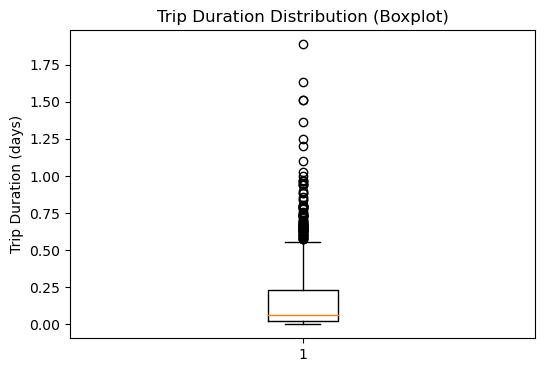

In [153]:
movement_df['move_duration_days'] = movement_df['move_duration'] / (60 * 24)

plt.figure(figsize=(6, 4))
plt.boxplot(movement_df['move_duration_days'], vert=True)
plt.ylabel('Trip Duration (days)')
plt.title('Trip Duration Distribution (Boxplot)')
plt.show()

In [154]:
movement_df['move_duration_td'] = pd.to_timedelta(movement_df['move_duration'], unit='m')

one_day = pd.Timedelta(days=1)

num_long_trips = (movement_df['move_duration_td'] > one_day).sum()
print("Number of trips > 1 day:", num_long_trips)
print("Proportion trips > 1 day:", num_long_trips / len(movement_df))

unique_plates = movement_df.loc[
    movement_df['move_duration_td'] > one_day, 'licencePlate'
].nunique()
print("Unique licence plates with rental > 1 day:", unique_plates)


Number of trips > 1 day: 10
Proportion trips > 1 day: 0.008880994671403197
Unique licence plates with rental > 1 day: 10


#### Filter the >1 day trips

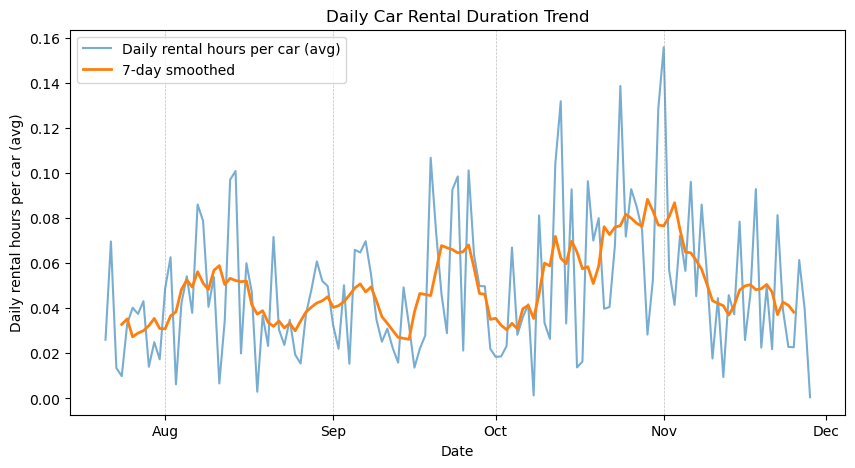

In [155]:
movement_df_filtered = movement_df[movement_df['move_duration'] <= 1440].copy()

daily_use_filtered = movement_df_filtered.groupby('date')['rental_minutes'].sum().reset_index()
daily_use_filtered['total_hours'] = daily_use_filtered['rental_minutes'] / 60
daily_use_filtered['av_rent_hour_per_car'] = daily_use_filtered['total_hours'] / n_cars

daily_use_filtered = daily_use_filtered.sort_values('date')

daily_use_filtered['rental_smooth'] = daily_use_filtered['av_rent_hour_per_car'].rolling(window=7, center=True).mean()

# Plot
plt.figure(figsize=(10,5))
plt.plot(daily_use_filtered['date'], daily_use_filtered['av_rent_hour_per_car'], label='Daily rental hours per car (avg)', alpha=0.6)
plt.plot(daily_use_filtered['date'], daily_use_filtered['rental_smooth'], label='7-day smoothed', linewidth=2)

ax = plt.gca()
for d in pd.date_range(daily_use_filtered['date'].min(), daily_use_filtered['date'].max(), freq='MS'):
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())       
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  

plt.xlabel('Date')
plt.ylabel('Daily rental hours per car (avg)')
plt.title('Daily Car Rental Duration Trend')
plt.legend()
plt.show() 

In [156]:
movement_df_filtered.columns

Index(['licencePlate', 'start_move_time', 'end_move_time', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'start_zip', 'end_zip',
       'move_duration', 'vehicleTypeId', 'type', 'rental_minutes', 'date',
       'move_duration_days', 'move_duration_td'],
      dtype='object')

### Aggregating by day of the month (only August, September, October)

In [157]:
full_months = ['2025-08', '2025-09', '2025-10']  

movement_df_filtered['date'] = pd.to_datetime(movement_df_filtered['date'])

movement_df_3m = movement_df_filtered[
    movement_df_filtered['date'].dt.to_period('M').astype(str).isin(full_months)
].copy()


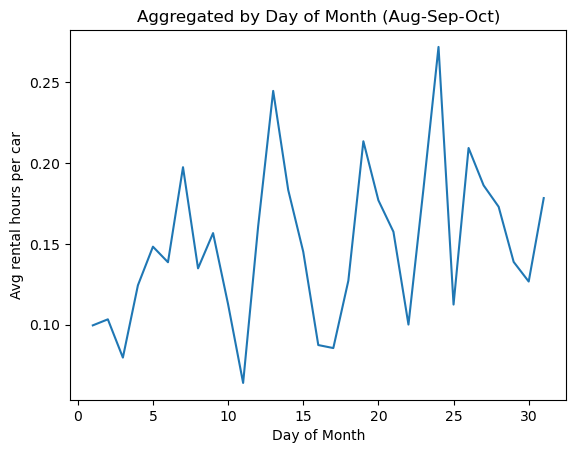

In [158]:
movement_df_3m['day_of_month'] = movement_df_3m['date'].dt.day

dom_pattern = (
    movement_df_3m.groupby('day_of_month')['rental_minutes'].sum()
    / 60 / n_cars
)

plt.plot(dom_pattern.index, dom_pattern.values)
plt.xlabel("Day of Month")
plt.ylabel("Avg rental hours per car")
plt.title("Aggregated by Day of Month (Aug-Sep-Oct)")
plt.show()

#### Agreggating by day of the week

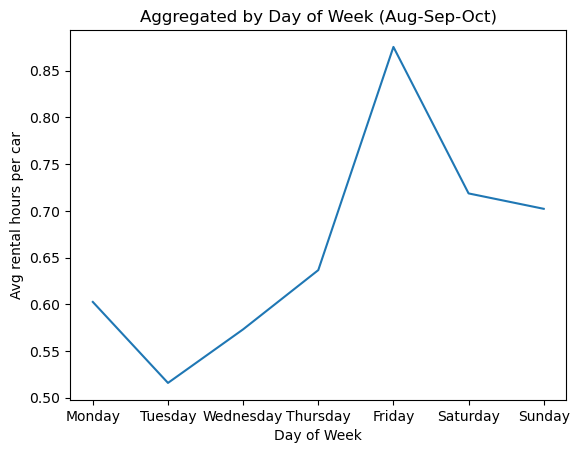

In [159]:
movement_df_3m['day_of_week'] = movement_df_3m['date'].dt.day_name()

dow_pattern = (
    movement_df_3m.groupby('day_of_week')['rental_minutes'].sum()
    / 60 / n_cars 
)

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_pattern = dow_pattern.reindex(dow_order)

plt.plot(dow_pattern.index, dow_pattern.values)
plt.xlabel("Day of Week")
plt.ylabel("Avg rental hours per car")
plt.title("Aggregated by Day of Week (Aug-Sep-Oct)")
plt.show()

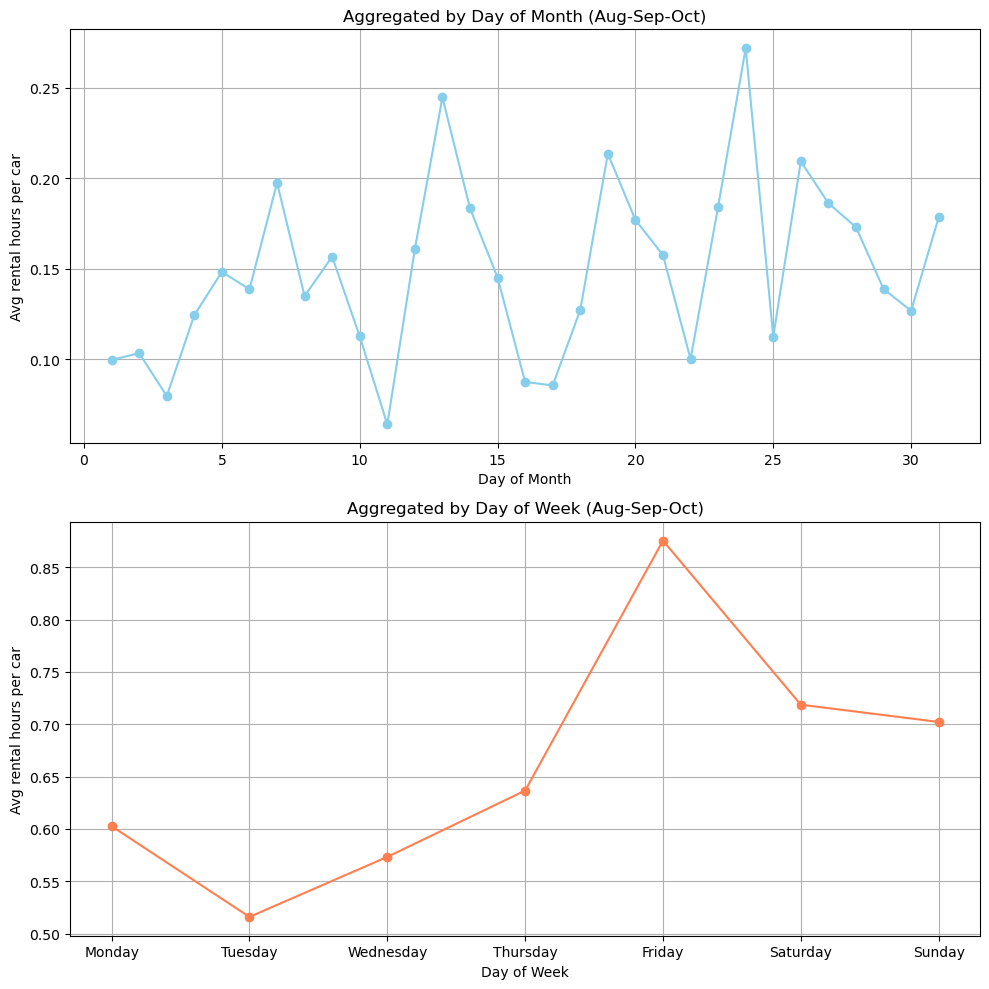

In [160]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

axes[0].plot(dom_pattern.index, dom_pattern.values, marker='o', color='skyblue')
axes[0].set_xlabel("Day of Month")
axes[0].set_ylabel("Avg rental hours per car")
axes[0].set_title("Aggregated by Day of Month (Aug-Sep-Oct)")
axes[0].grid(True)

axes[1].plot(dow_pattern.index, dow_pattern.values, marker='o', color='coral')
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Avg rental hours per car")
axes[1].set_title("Aggregated by Day of Week (Aug-Sep-Oct)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Decomposition

In [161]:
daily_use = daily_use_filtered

In [162]:
daily_use.head(1)

,date,rental_minutes,total_hours,av_rent_hour_per_car,rental_smooth
0,2025-07-21,1060.0,17.666667,0.026057,NaN


In [163]:
result = seasonal_decompose(
    daily_use['av_rent_hour_per_car'],
    model='additive', 
    period=7  # weekly pattern
)

In [164]:
trend = result.trend
seasonal = result.seasonal
resid = result.resid
observed = result.observed

denoised = trend + seasonal
detrended = observed - trend 

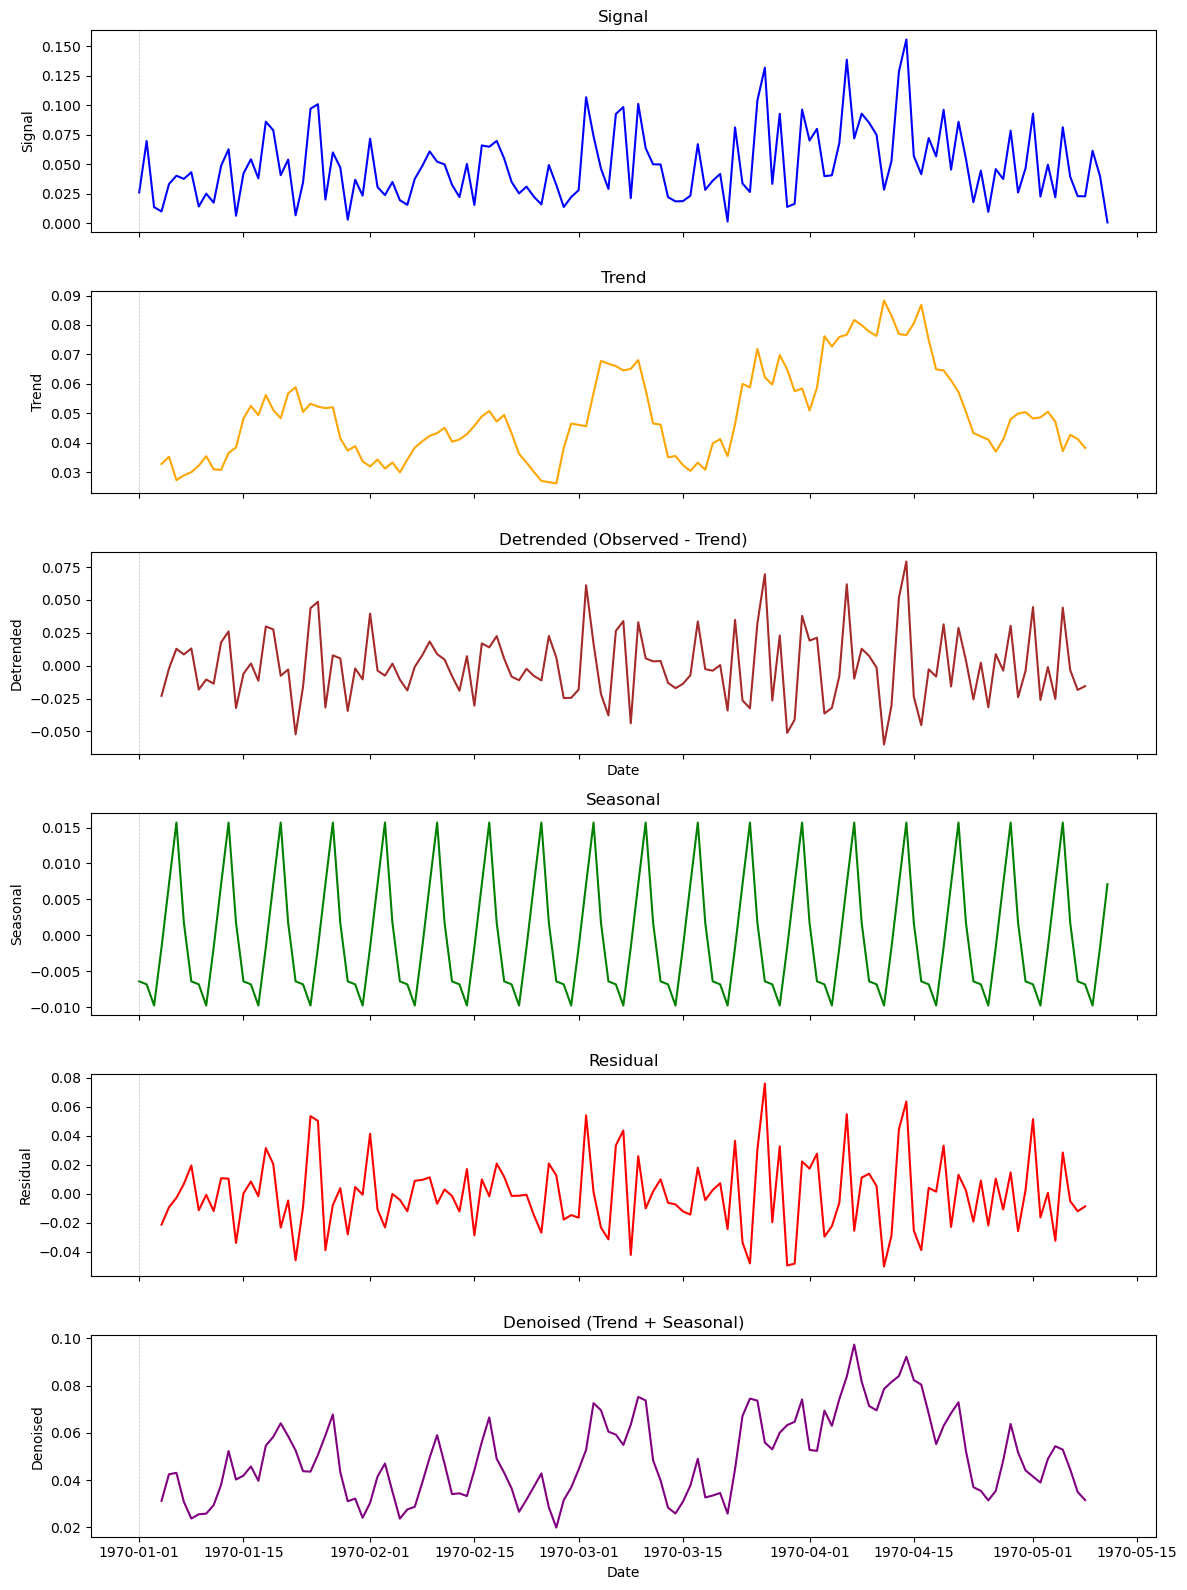

In [165]:
# Plot
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

axes[0].plot(observed.index, observed, color='blue')
axes[0].set_ylabel('Signal')
axes[0].set_title('Signal')

axes[1].plot(trend.index, trend, color='orange')
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend')

axes[2].plot(detrended.index, detrended, color='brown')
axes[2].set_ylabel('Detrended')
axes[2].set_title('Detrended (Observed - Trend)')
axes[2].set_xlabel('Date')

axes[3].plot(seasonal.index, seasonal, color='green')
axes[3].set_ylabel('Seasonal')
axes[3].set_title('Seasonal')

axes[4].plot(resid.index, resid, color='red')
axes[4].set_ylabel('Residual')
axes[4].set_title('Residual')

axes[5].plot(denoised.index, denoised, color='purple')
axes[5].set_ylabel('Denoised')
axes[5].set_title('Denoised (Trend + Seasonal)')
axes[5].set_xlabel('Date')

first_days = pd.date_range(start=observed.index.min(), end=observed.index.max(), freq='MS')
for ax in axes:
    for d in first_days:
        ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()


## Comparison cars vs vans

In [166]:
movement_df_filtered.columns

Index(['licencePlate', 'start_move_time', 'end_move_time', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'start_zip', 'end_zip',
       'move_duration', 'vehicleTypeId', 'type', 'rental_minutes', 'date',
       'move_duration_days', 'move_duration_td'],
      dtype='object')

In [168]:
movement_df_filtered[['vehicleTypeId', 'type']].head(3)

,vehicleTypeId,type
0,2,car
1,2,car
2,2,car


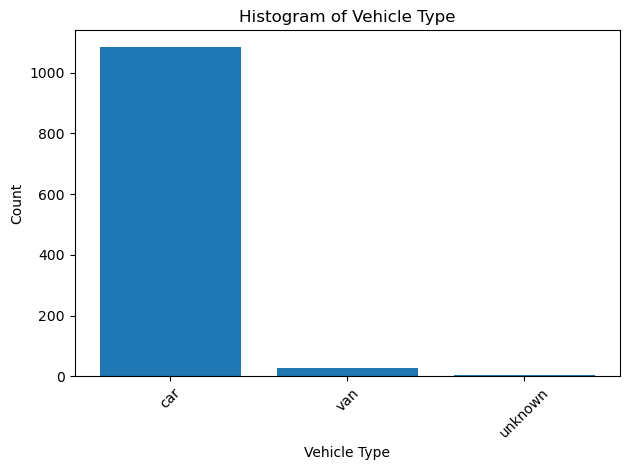

In [169]:
counts = movement_df_filtered['type'].value_counts()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.title('Histogram of Vehicle Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [171]:
vehicle_type_counts = movement_df_filtered.groupby('type')['licencePlate'].nunique()
print(vehicle_type_counts)

type
car        649
unknown      2
van         23
Name: licencePlate, dtype: int64


/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_10559/1767986726.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_cars = vehicle_type_counts[0]
/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_10559/1767986726.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_vans = vehicle_type_counts[2]


Num cars: 649
Num vans: 23


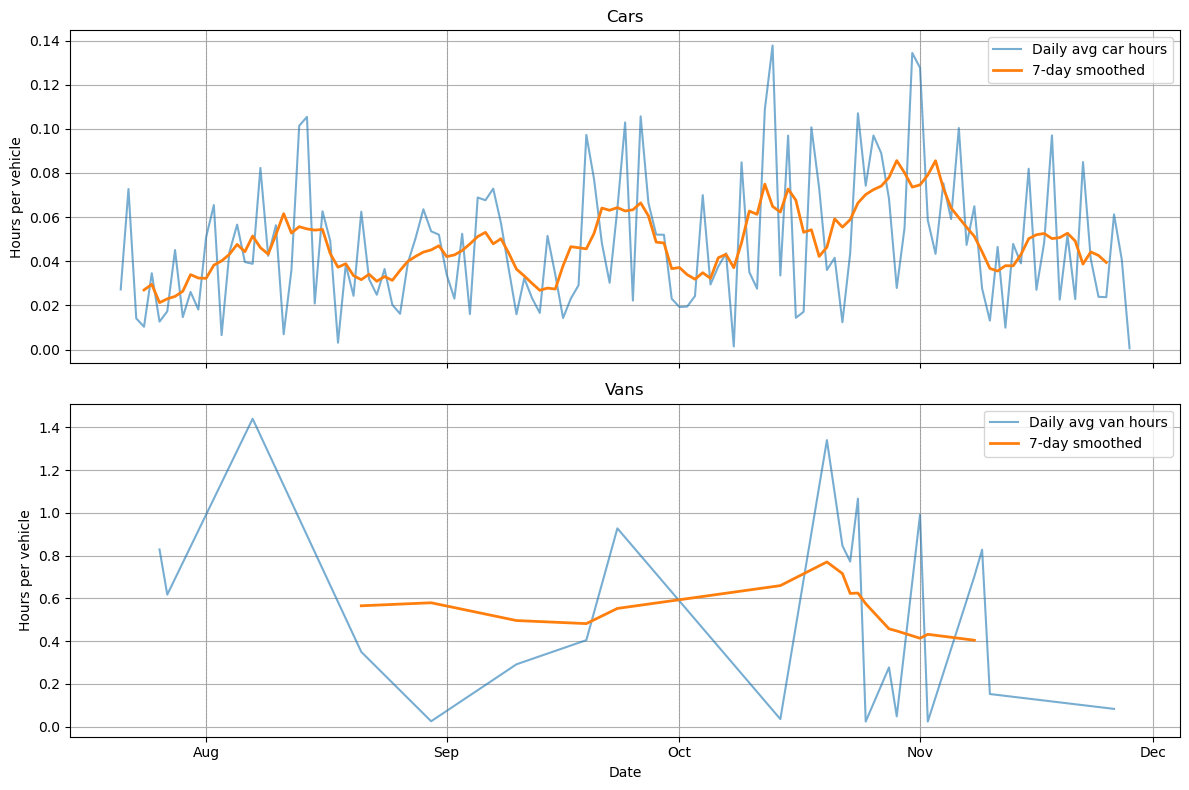

In [174]:
# n_cars = (movement_df_filtered['vehicle_type'] == 'car').sum()
# n_vans = (movement_df_filtered['vehicle_type'] == 'van').sum()

n_cars = vehicle_type_counts[0]
n_vans = vehicle_type_counts[2]
print('Num cars:', n_cars)
print('Num vans:', n_vans)


daily_use_type = (
    movement_df_filtered.groupby(['date','type'])['rental_minutes']
    .sum()
    .reset_index()
)

daily_use_type['total_hours'] = daily_use_type['rental_minutes'] / 60
daily_use_type['av_rent_hour_per_vehicle'] = daily_use_type.apply(
    lambda row: row['total_hours'] / (n_cars if row['type']=='car' else n_vans), axis=1
)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i, vtype in enumerate(['car','van']):
    df_plot = daily_use_type[daily_use_type['type']==vtype].sort_values('date')
    df_plot['rental_smooth'] = df_plot['av_rent_hour_per_vehicle'].rolling(window=7, center=True).mean()
    
    axes[i].plot(df_plot['date'], df_plot['av_rent_hour_per_vehicle'], label=f'Daily avg {vtype} hours', alpha=0.6)
    axes[i].plot(df_plot['date'], df_plot['rental_smooth'], label='7-day smoothed', linewidth=2)
    
    for d in pd.date_range(df_plot['date'].min(), df_plot['date'].max(), freq='MS'):
        axes[i].axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    axes[i].set_ylabel('Hours per vehicle')
    axes[i].set_title(f'{vtype.capitalize()}s')
    axes[i].legend()
    axes[i].grid(True)

axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('Date')

plt.tight_layout()
plt.show()



### Decomposition - car vs van

In [179]:
results = {}  

for vtype in ['car', 'van']:

    s = (
        daily_use_type[daily_use_type['type'] == vtype]
        .sort_values('date')
        .set_index('date')['av_rent_hour_per_vehicle']
        .asfreq('D')                  
        .interpolate('time')             
    )
    result = seasonal_decompose(
    s,
    model='additive',
    period=7,   
    extrapolate_trend='freq' 
    )

    results[vtype] = result

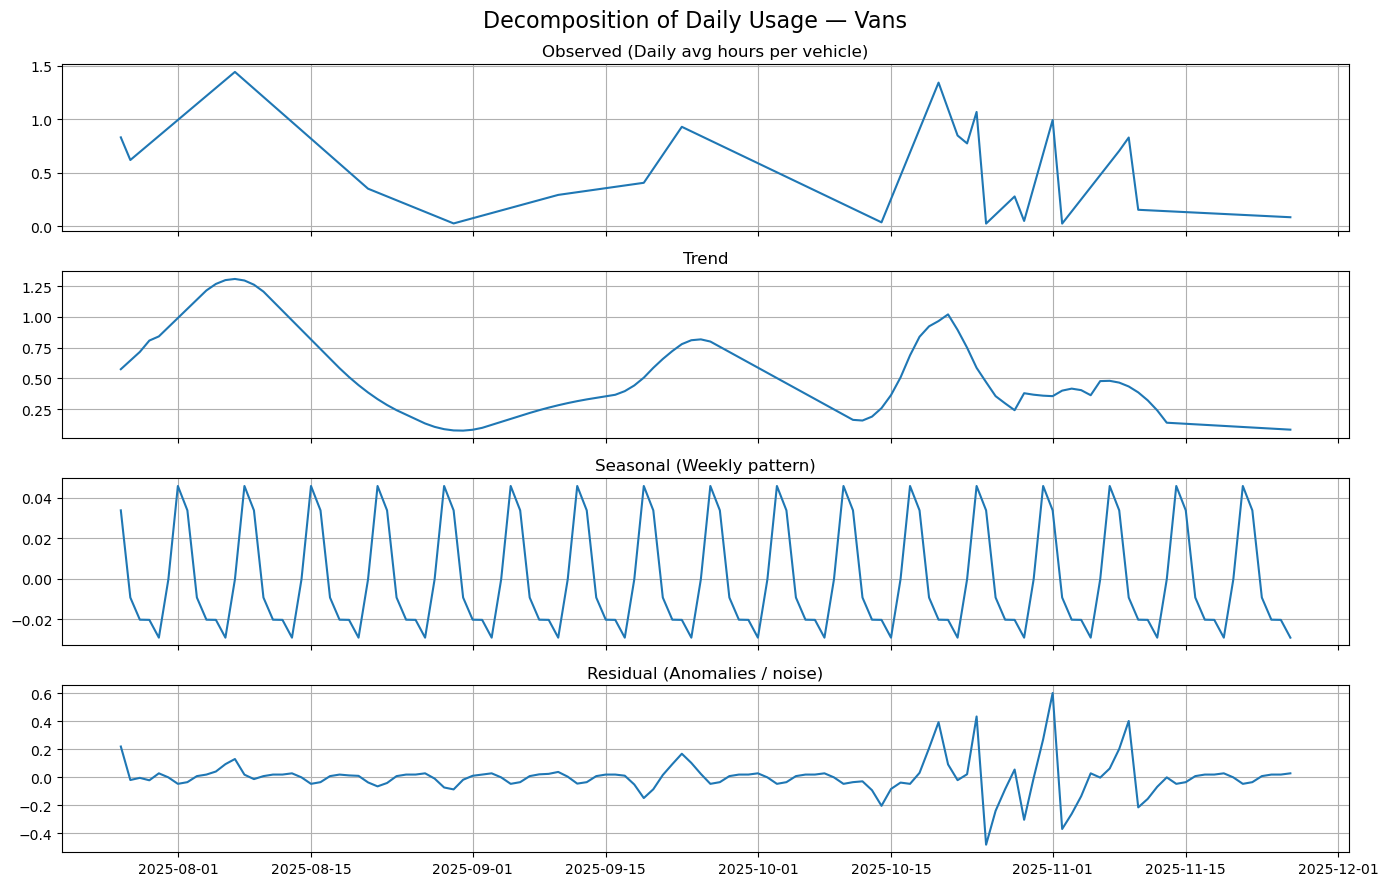

In [180]:
fig, axes = plt.subplots(4, 1, figsize=(14, 9), sharex=True)

fig.suptitle(f"Decomposition of Daily Usage — {vtype.capitalize()}s", fontsize=16)

axes[0].plot(result.observed)
axes[0].set_title("Observed (Daily avg hours per vehicle)")
axes[0].grid(True)

axes[1].plot(result.trend)
axes[1].set_title("Trend")
axes[1].grid(True)

axes[2].plot(result.seasonal)
axes[2].set_title("Seasonal (Weekly pattern)")
axes[2].grid(True)

axes[3].plot(result.resid)
axes[3].set_title("Residual (Anomalies / noise)")
axes[3].grid(True)

plt.tight_layout()
plt.show()


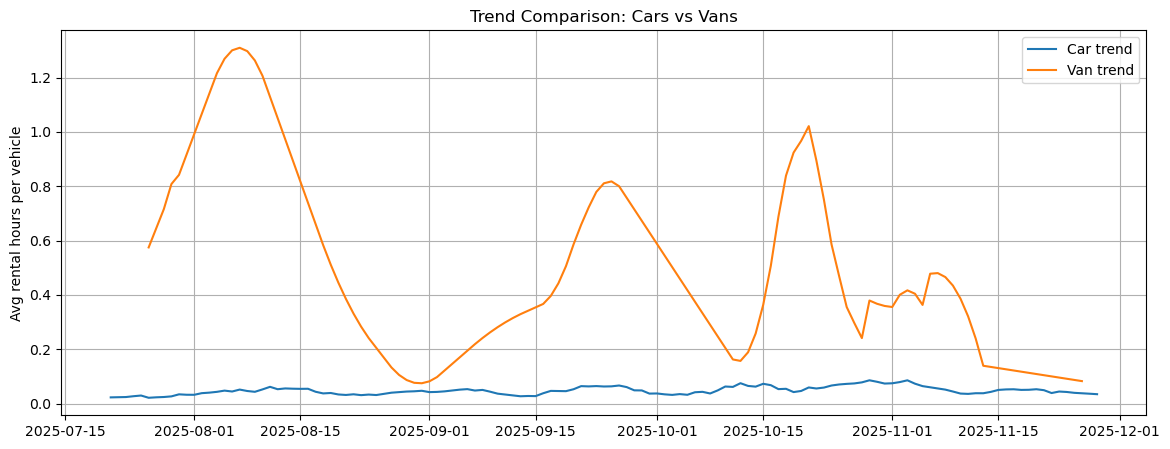

In [181]:
car_trend = results['car'].trend.rename("car_trend")
van_trend = results['van'].trend.rename("van_trend")

trend_df = pd.concat([car_trend, van_trend], axis=1)

plt.figure(figsize=(14,5))
plt.plot(trend_df.index, trend_df['car_trend'], label="Car trend")
plt.plot(trend_df.index, trend_df['van_trend'], label="Van trend")
plt.title("Trend Comparison: Cars vs Vans")
plt.ylabel("Avg rental hours per vehicle")
plt.legend()
plt.grid(True)
plt.show()

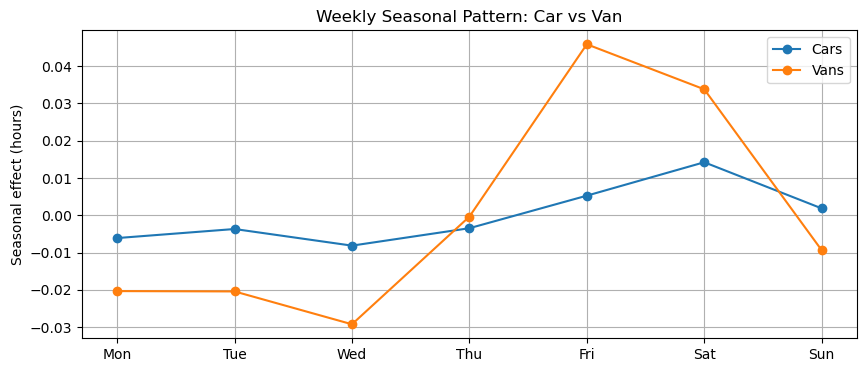

In [182]:
car_season = results['car'].seasonal.groupby(results['car'].seasonal.index.dayofweek).mean()
van_season = results['van'].seasonal.groupby(results['van'].seasonal.index.dayofweek).mean()

plt.figure(figsize=(10,4))
plt.plot(car_season.index, car_season.values, marker='o', label='Cars')
plt.plot(van_season.index, van_season.values, marker='o', label='Vans')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title("Weekly Seasonal Pattern: Car vs Van")
plt.ylabel("Seasonal effect (hours)")
plt.legend()
plt.grid(True)
plt.show()

### Day of month/week analysis - car vs van

In [183]:
movement_df_3m['type'] = movement_df_3m['vehicleTypeId'].map(type_map)
movement_df_3m[['vehicleTypeId', 'vehicle_type']].head(3)

NameError: name 'type_map' is not defined

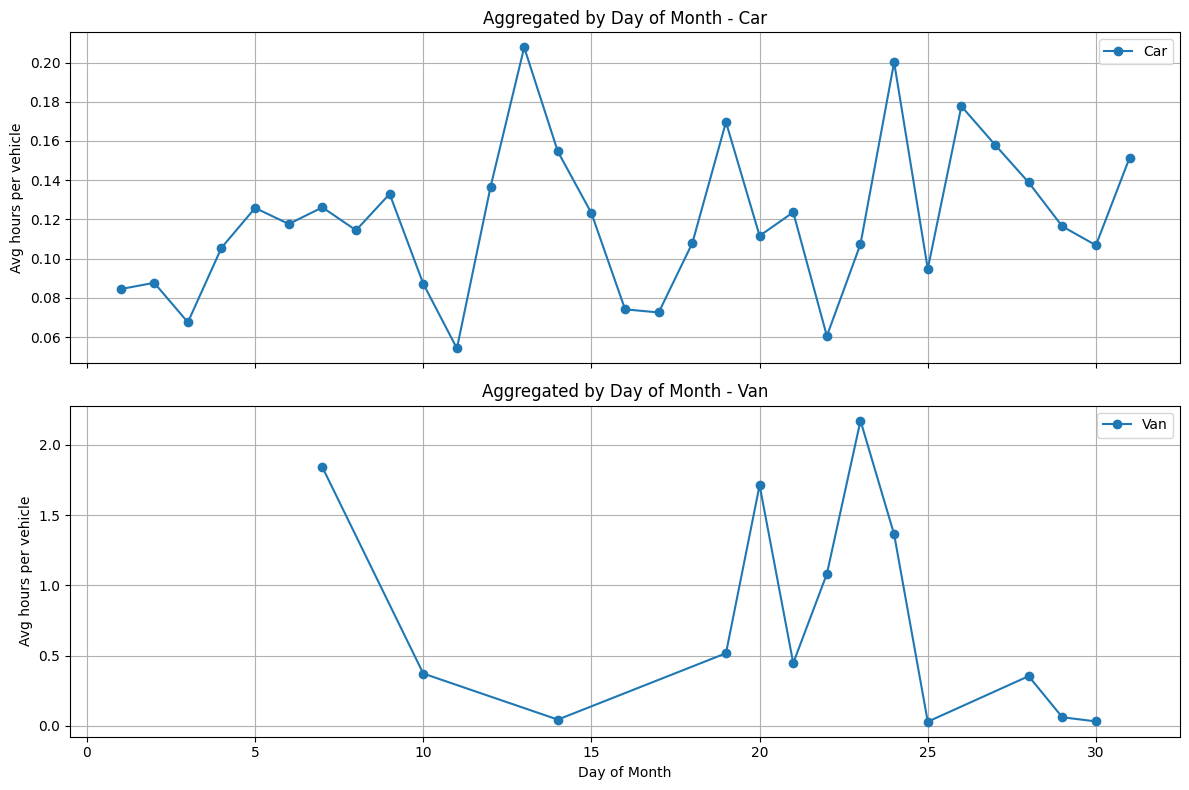

In [ ]:
n_cars = (movement_df_3m['vehicle_type'] == 'car').sum()
n_vans = (movement_df_3m['vehicle_type'] == 'van').sum()

fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

for i, vtype in enumerate(['car','van']):
    df_type = movement_df_3m[movement_df_3m['vehicle_type']==vtype].copy()
    
    df_type['day_of_month'] = df_type['date'].dt.day
    
    dom_pattern = (
        df_type.groupby('day_of_month')['rental_minutes'].sum()
        / 60 / (n_cars if vtype=='car' else n_vans)
    )
    
    axes[i].plot(dom_pattern.index, dom_pattern.values, marker='o', label=vtype.capitalize())
    axes[i].set_ylabel("Avg hours per vehicle")
    axes[i].set_title(f"Aggregated by Day of Month - {vtype.capitalize()}")
    axes[i].grid(True)
    axes[i].legend()

plt.xlabel("Day of Month")
plt.tight_layout()
plt.show()


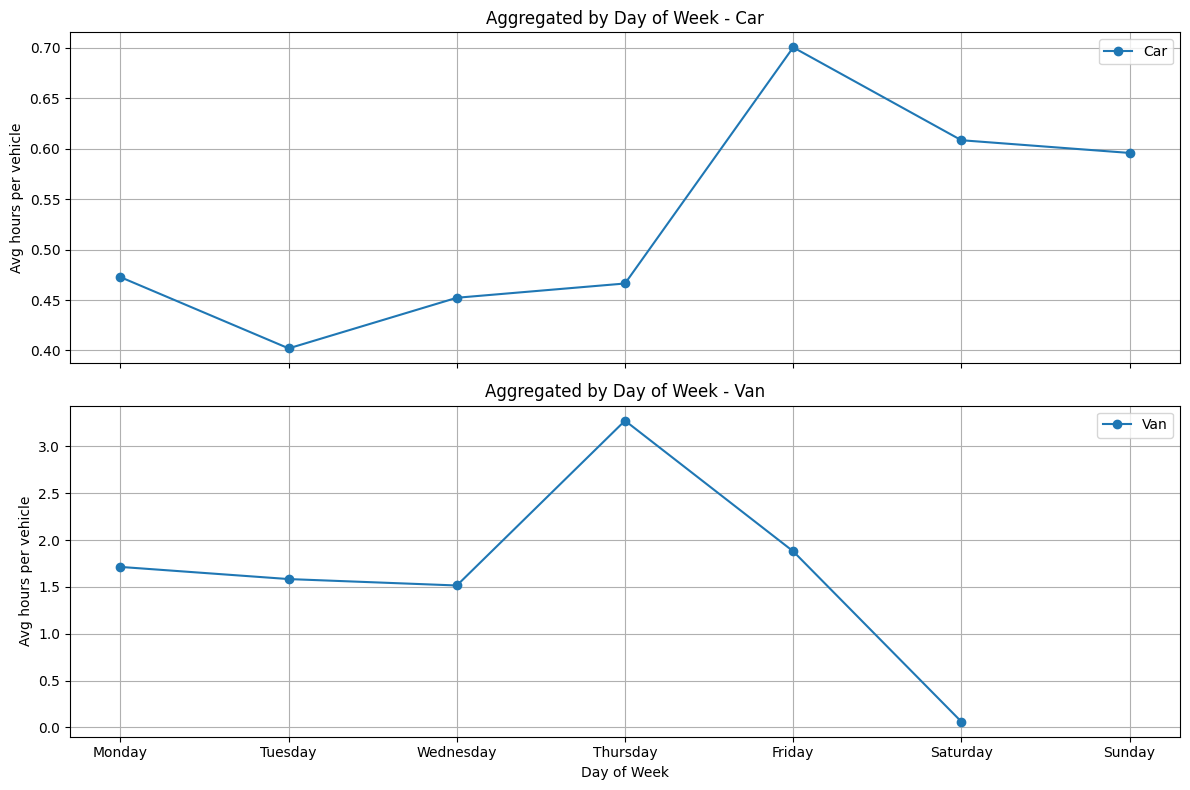

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, vtype in enumerate(['car','van']):
    df_type = movement_df_3m[movement_df_3m['vehicle_type']==vtype].copy()
    
    df_type['day_of_week'] = df_type['date'].dt.day_name()
    
    dow_pattern = (
        df_type.groupby('day_of_week')['rental_minutes'].sum()
        / 60 / (n_cars if vtype=='car' else n_vans)
    ).reindex(dow_order)
    
    axes[i].plot(dow_pattern.index, dow_pattern.values, marker='o', label=vtype.capitalize())
    axes[i].set_ylabel("Avg hours per vehicle")
    axes[i].set_title(f"Aggregated by Day of Week - {vtype.capitalize()}")
    axes[i].grid(True)
    axes[i].legend()

plt.xlabel("Day of Week")
plt.tight_layout()
plt.show()


____________
## Is data stationary?

(Dont think we need. Delete after)

In [184]:
from statsmodels.tsa.stattools import adfuller, kpss

In [185]:
df = daily_use.copy()
df['av_hours_log'] = np.log(df['av_rent_hour_per_car'])
df['av_hours_diff'] = df['av_rent_hour_per_car'] - df['av_rent_hour_per_car'].shift(1)
df['av_hours_return'] = df['av_rent_hour_per_car'] / df['av_rent_hour_per_car'].shift(1)
df['av_hours_return_log'] = np.log(df['av_hours_return'])
df['av_hours_log_diff'] = df['av_hours_log'] - df['av_hours_log'].shift(1)


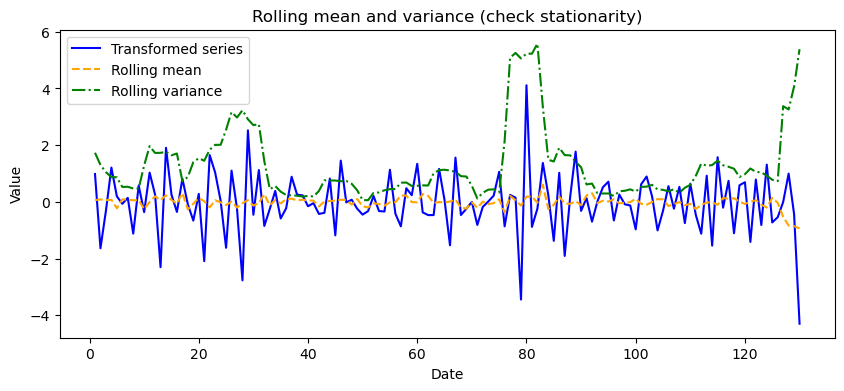

In [186]:
var = 'av_hours_log_diff'

df_plot = df[[var]].dropna()
rolling_mean = df_plot[var].rolling(window=7, min_periods=1, center=True).mean()
rolling_var = df_plot[var].rolling(window=7, min_periods=1, center=True).var()

plt.figure(figsize=(10,4))
plt.plot(df_plot.index, df_plot[var], color='blue', label='Transformed series')
plt.plot(df_plot.index, rolling_mean, '--', color='orange', label='Rolling mean')
plt.plot(df_plot.index, rolling_var, '-.', color='green', label='Rolling variance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Rolling mean and variance (check stationarity)')
plt.legend()
plt.show()


In [187]:
adf_result = adfuller(df_plot[var])
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical values:", adf_result[4])

kpss_result = kpss(df_plot[var], regression='c', nlags='auto')
print("KPSS Test Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
print("Critical values:", kpss_result[3])


ADF Test Statistic: -4.240313749318708
p-value: 0.0005626776383487867
Critical values: {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}
KPSS Test Statistic: 0.3219561701814274
p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_10559/3853866936.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_plot[var], regression='c', nlags='auto')


#### Result: Series is stationary